In [65]:
import torch
import torch.nn as nn  # All neural network modules
import torch.optim as optim # For optimizers like SGD
from torch.utils.data import TensorDataset, random_split, DataLoader  # Gives easier dataset managment
from torchvision import datasets, transforms
import matplotlib.pyplot as plt  # draw plots
# torch.manual_seed(2025) # set random seed

# MNIST dataset

In [66]:
# Define how we transform the dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to a PyTorch tensor and scale pixel values to [0,1]
    transforms.Normalize((0.1307,), (0.3081,)),  # Normalize using MNIST mean and std
    transforms.Lambda(lambda x: torch.flatten(x))  # Flatten (1, 28, 28) images into 1D (784,) vectors
])

# read dataset
train_dataset = datasets.MNIST(root='./MNIST', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./MNIST', train=False, transform=transform)

In [67]:
# Split train into train/validation
# validation set is served to monitor val_loss in early stopping and also in parameter tuning
train_dataset, val_dataset = random_split(train_dataset, [50000, 10000])

In [68]:
# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define the model architecture

In [ ]:
class myFCN(nn.Module):
    def __init__(self, dropout_prob=0.3):
        super(myFCN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 512), # the input size is 784, the size of the first hidden layer is 512
            nn.ReLU(), # activation for the first hidden layer
            nn.Dropout(dropout_prob), # dropout probability of the first hidden layer
            nn.BatchNorm1d(512), # batch normalization

            nn.Linear(512, 256), # the size of the second hidden layer is 256
            nn.ReLU(), # activation for the second hidden layer
            nn.Dropout(dropout_prob/2), # dropout probability of the second hidden layer

            nn.Linear(256, 10) # the size of the output layer is 10 since MNIST has 10 digit classes
        )

        # Xavier initialization for weights, set bias to 0
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                # Initialize weights with Xavier Normal Initialization
                nn.init.xavier_normal_(layer.weight)
                # Initialize biases to zero
                nn.init.zeros_(layer.bias)
    
    def forward(self, x):
        return self.layers(x)
    
    

In [ ]:
# Initialize model with L2 regularization (weight decay)
model = myFCN()
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-3)  # weight_decay stands for L2 regularization
criterion = nn.CrossEntropyLoss() # loss function is cross entropy

# Training with Early Stopping

In [71]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []
best_val_loss = float('inf')
patience_counter = 0
patience = 5  # wait for 5 steps for early stopping

In [72]:
for epoch in range(50):
    # Training
    model.train() # set the model at training status
    epoch_train_loss, correct, total = 0, 0, 0
    for inputs, targets in train_loader:        
        optimizer.zero_grad()  # clear the previous gradient
        outputs = model(inputs) # forward propagation
        loss = criterion(outputs, targets)  # calculate loss
        loss.backward()  # calculate the gradient by backpropagation
        optimizer.step()  # one step in gradient descent
        
        epoch_train_loss += loss.item()
        _, predicted = outputs.max(1)  # get the predicted label
        total += targets.size(0) # count the total sample size
        correct += predicted.eq(targets).sum().item() # if prediction==target, count as correct
    
    train_loss = epoch_train_loss/len(train_loader)
    train_acc = 100*correct/total
    
    # Validation
    model.eval() # set the model at evaluation status
    epoch_val_loss, correct, total = 0, 0, 0
    with torch.no_grad():  # we do not need to calculate gradient in evaluation
        for inputs, targets in val_loader:            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            epoch_val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    val_loss = epoch_val_loss/len(val_loader)
    val_acc = 100*correct/total
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save best model
    else:
        patience_counter += 1
    
    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} | '
          f'Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    if patience_counter >= patience:
        print("Early stopping!")
        break

Epoch 1: Train Loss: 1.8650, Val Loss: 1.0593 | Train Acc: 38.61%, Val Acc: 72.14%
Epoch 2: Train Loss: 1.0554, Val Loss: 0.7080 | Train Acc: 67.63%, Val Acc: 81.49%
Epoch 3: Train Loss: 0.7993, Val Loss: 0.5608 | Train Acc: 75.93%, Val Acc: 85.49%
Epoch 4: Train Loss: 0.6700, Val Loss: 0.4780 | Train Acc: 80.00%, Val Acc: 87.14%
Epoch 5: Train Loss: 0.5939, Val Loss: 0.4272 | Train Acc: 82.31%, Val Acc: 88.45%
Epoch 6: Train Loss: 0.5378, Val Loss: 0.3940 | Train Acc: 83.95%, Val Acc: 89.37%
Epoch 7: Train Loss: 0.4974, Val Loss: 0.3627 | Train Acc: 85.06%, Val Acc: 90.02%
Epoch 8: Train Loss: 0.4647, Val Loss: 0.3414 | Train Acc: 86.00%, Val Acc: 90.57%
Epoch 9: Train Loss: 0.4438, Val Loss: 0.3253 | Train Acc: 86.80%, Val Acc: 90.98%
Epoch 10: Train Loss: 0.4184, Val Loss: 0.3104 | Train Acc: 87.51%, Val Acc: 91.30%
Epoch 11: Train Loss: 0.4041, Val Loss: 0.2987 | Train Acc: 87.96%, Val Acc: 91.44%
Epoch 12: Train Loss: 0.3900, Val Loss: 0.2873 | Train Acc: 88.22%, Val Acc: 91.80%
E

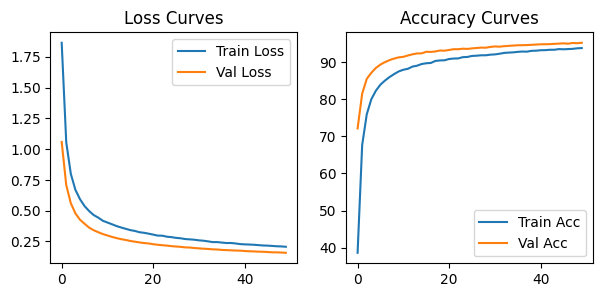

In [73]:
# visualize the loss 
plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curves')
plt.legend()

# visualize the accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Accuracy Curves')
plt.legend()
plt.show()

# Evaluation using test set

In [74]:
# load the best model
model.load_state_dict(torch.load('best_model.pth'))

model.eval() # set the model at evaluation status
total_test_loss, correct, total = 0, 0, 0
with torch.no_grad():  # we do not need to calculate gradient in evaluation
    for inputs, targets in test_loader:            
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        total_test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

# calcualte the loss and accuracy
test_loss = total_test_loss/len(test_loader)
test_acc = 100*correct/total

print(f'Train Loss: {test_loss:.4f}| '
      f'Test Acc: {test_acc:.2f}%')

Train Loss: 0.1511| Test Acc: 95.48%


# Tuning example
We have many tuning parameters in the above neural network. 

The key tunable parameters include dropout probability, batch size, L2 regularization strength, learning rate, network architecture, early stopping patience.

There are also some other details that we can tune: the optimization method, the activation function, etc.. 

In the following, we give an example showing how to tune **batch size** and **dropout probability**. 

In [31]:
# set hyperparameters to tune
hyperparam_grid = {
    'batch_size': [64, 128, 256],    # Different mini-batch sizes
    'dropout_prob': [0.1, 0.5, 0.7]  # Dropout probabilities to test
}

In [ ]:
# for each group of given hyperparameters, return the best validation error for comparison
def train_evaluate_model(batch_size, dropout_prob):
    """Trains model with given hyperparameters and returns validation accuracy"""
    # Create data loader with current batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1024)
    
    # Initialize model and optimizer
    model = myFCN(dropout_prob)
    optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-3)
    criterion = nn.CrossEntropyLoss()
    
    # Early stopping setup
    best_val_acc = 0
    patience_counter = 0
    patience = 5
    
    for epoch in range(50):
        # Training phase
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        
        # Validation phase
        model.eval()
        val_correct = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                val_correct += (outputs.argmax(1) == targets).sum().item()
        
        val_acc = val_correct / len(val_dataset)
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            break
    
    return best_val_acc


In [32]:
# grid search of tuning parameters to get the best model
results = {}
best_acc = 0
best_params = {}

for batch_size in hyperparam_grid['batch_size']:
    for dropout_prob in hyperparam_grid['dropout_prob']:
        print(f"\nTraining with batch_size={batch_size}, dropout={dropout_prob}")
        val_acc = train_evaluate_model(batch_size, dropout_prob)
        results[(batch_size, dropout_prob)] = val_acc
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_params = {'batch_size': batch_size, 'dropout_prob': dropout_prob}


Training with batch_size=64, dropout=0.1

Training with batch_size=64, dropout=0.5

Training with batch_size=64, dropout=0.7

Training with batch_size=128, dropout=0.1

Training with batch_size=128, dropout=0.5

Training with batch_size=128, dropout=0.7

Training with batch_size=256, dropout=0.1

Training with batch_size=256, dropout=0.5

Training with batch_size=256, dropout=0.7


In [33]:
best_params

{'batch_size': 64, 'dropout_prob': 0.1}